## This is notebook for putting all the models so far in a nice format and making plots for the final presentations
#### Version 1.0 by YY on Dec 6th 2023

### Import libraries and packages

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import time

### Device managment

In [2]:
# For CoLab or Nvdia device, run this cell
device = 'cuda' if torch.cuda.is_available() else 'cpu' # using gpu or cpu
print(device)

cpu


In [23]:
# For Macbook M series chipset, use MPS instead, run this cell

# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available")
    else:
        print("MPS not available")
else:
    device = torch.device("mps")
print(device)

mps


### Data import

In [3]:
# Import data
### For google Colab
#filepath = '/content/drive/MyDrive/Colab Notebooks/Project/'

### For Macbook of YY
filepath = '/Users/yorkie/Desktop/CISC684/Project/'


dataset = pd.read_csv(os.path.join(filepath, 'train.csv'),names=['Store','Dept','Date','weeklySales','isHoliday'],sep=',', header=0)
dataset['Date'] = pd.to_datetime(dataset['Date'])
print(dataset.head(5))

features = pd.read_csv(os.path.join(filepath, 'features.csv'),sep=',', header=0,
                       names=['Store','Date','Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4',
                              'MarkDown5','CPI','Unemployment','IsHoliday']).drop(columns=['IsHoliday'])
features['Date'] = pd.to_datetime(features['Date'])
#features['Temperature_norm'] = features['Temperature'].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
features['Temperature_norm'] = (features['Temperature'] - features['Temperature'].min()) / (features['Temperature'].max() - features['Temperature'].min())
features['Fuel_Price_norm'] = (features['Fuel_Price'] - features['Fuel_Price'].min()) / (features['Fuel_Price'].max() - features['Fuel_Price'].min())
features['CPI_norm'] = (features['CPI'] - features['CPI'].min()) / (features['CPI'].max() - features['CPI'].min())
features['Unemployment_norm'] = (features['Unemployment'] - features['Unemployment'].min()) / (features['Unemployment'].max() - features['Unemployment'].min())

print(features.head(5))

stores = pd.read_csv(os.path.join(filepath, 'stores.csv'), names=['Store','Type','Size'],sep=',', header=0)
stores['Size_norm'] = (stores['Size'] - stores['Size'].min()) / (stores['Size'].max() - stores['Size'].min())

min_value = dataset['weeklySales'].min()  # Store the minimum value
max_value = dataset['weeklySales'].max()  # Store the maximum value





   Store  Dept       Date  weeklySales  isHoliday
0      1     1 2010-02-05     24924.50      False
1      1     1 2010-02-12     46039.49       True
2      1     1 2010-02-19     41595.55      False
3      1     1 2010-02-26     19403.54      False
4      1     1 2010-03-05     21827.90      False
   Store       Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  \
0      1 2010-02-05        42.31       2.572        NaN        NaN        NaN   
1      1 2010-02-12        38.51       2.548        NaN        NaN        NaN   
2      1 2010-02-19        39.93       2.514        NaN        NaN        NaN   
3      1 2010-02-26        46.63       2.561        NaN        NaN        NaN   
4      1 2010-03-05        46.50       2.625        NaN        NaN        NaN   

   MarkDown4  MarkDown5         CPI  Unemployment  Temperature_norm  \
0        NaN        NaN  211.096358         8.106          0.454046   
1        NaN        NaN  211.242170         8.106          0.419260   


In [4]:
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset['weeklySales'] = scaler.fit_transform(dataset['weeklySales'].values.reshape(-1,1))

print(dataset['weeklySales'])
print('weeklySales.shape = ', dataset['weeklySales'].shape)

0        -0.914299
1        -0.853805
2        -0.866537
3        -0.930116
4        -0.923171
            ...   
421565   -0.984250
421566   -0.983907
421567   -0.982667
421568   -0.983529
421569   -0.982622
Name: weeklySales, Length: 421570, dtype: float64
weeklySales.shape =  (421570,)


In [5]:
lookback = 5
#dataset['Week'] = dataset.Date.dt.isocalendar().week
lead_5 = dataset.groupby(['Store','Dept'])[['Store', 'Dept', 'weeklySales']].shift(-lookback)
lead_4 = dataset.groupby(['Store','Dept'])[['Store', 'Dept', 'weeklySales']].shift(-lookback + 1)
lead_3 = dataset.groupby(['Store','Dept'])[['Store', 'Dept', 'weeklySales']].shift(-lookback + 2)
lead_2 = dataset.groupby(['Store','Dept'])[['Store', 'Dept', 'weeklySales']].shift(-lookback + 3)
lead_1 = dataset.groupby(['Store','Dept'])[['Store', 'Dept', 'weeklySales']].shift(-lookback + 4)


dataset['weeklySales_5'] = lead_5['weeklySales']
dataset['weeklySales_4'] = lead_4['weeklySales']
dataset['weeklySales_3'] = lead_3['weeklySales']
dataset['weeklySales_2'] = lead_2['weeklySales']
dataset['weeklySales_1'] = lead_1['weeklySales']

In [6]:
# Merge data
raw = dataset.merge(stores, how='left').merge(features, how='left')
raw = raw.dropna(subset = ['weeklySales','weeklySales_5','weeklySales_1','weeklySales_3','weeklySales_4','weeklySales_2'])
print(raw.head(5))

   Store  Dept       Date  weeklySales  isHoliday  weeklySales_5  \
0      1     1 2010-02-05    -0.914299      False      -0.925418   
1      1     1 2010-02-12    -0.853805       True      -0.922286   
2      1     1 2010-02-19    -0.866537      False      -0.910561   
3      1     1 2010-02-26    -0.930116      False      -0.821663   
4      1     1 2010-03-05    -0.923171      False      -0.862625   

   weeklySales_4  weeklySales_3  weeklySales_2  weeklySales_1  ... MarkDown2  \
0      -0.923171      -0.930116      -0.866537      -0.853805  ...       NaN   
1      -0.925418      -0.923171      -0.930116      -0.866537  ...       NaN   
2      -0.922286      -0.925418      -0.923171      -0.930116  ...       NaN   
3      -0.910561      -0.922286      -0.925418      -0.923171  ...       NaN   
4      -0.821663      -0.910561      -0.922286      -0.925418  ...       NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  \
0        NaN        NaN        NaN  211.096358

In [7]:
# Data Managment

raw['Week'] = raw.Date.dt.isocalendar().week
raw['Month'] = raw.Date.dt.month
raw['Year'] = raw.Date.dt.year
#raw['Year_Week'] = str(raw['Year']) + ' - ' + str(raw['Month'])

# Derived from a scatterplot of avg weekly sales by department
raw['Dept_Group1_Ind'] = np.where(raw['Dept'].isin([38, 95, 92]), 1, 0)
raw['Dept_Group2_Ind'] = np.where(raw['Dept'].isin([65, 2, 40, 90, 72]), 1, 0)
raw['Dept_Group3_Ind'] = np.where(~raw['Dept'].isin([38, 95, 92, 65, 2, 40, 90, 72]), 1, 0)
#print(raw[raw['Dept_Group3_Ind'] == 1]['Dept'].unique())

conditions = [
    raw['Size'] < 100000,
    (raw['Size'] >= 100000) & (raw['Size'] < 175000),
    raw['Size'] >= 175000
]
choices = ["Small", "Medium", "Large"]
raw['Size_Group'] = np.select(conditions, choices)

raw['CPI_Group'] = raw['CPI'].apply(lambda x: 1 if x < 160 else 0)
raw['Unemployment_Group'] = raw['Unemployment'].apply(lambda x: 1 if x < 5 else 0)


raw['MarkDown1_Ind'] = raw['MarkDown1'].apply(lambda x: 0 if pd.isna(x) else 1)
raw['MarkDown2_Ind'] = raw['MarkDown2'].apply(lambda x: 0 if pd.isna(x) else 1)
raw['MarkDown3_Ind'] = raw['MarkDown3'].apply(lambda x: 0 if pd.isna(x) else 1)
raw['MarkDown4_Ind'] = raw['MarkDown4'].apply(lambda x: 0 if pd.isna(x) else 1)
raw['MarkDown5_Ind'] = raw['MarkDown5'].apply(lambda x: 0 if pd.isna(x) else 1)
raw['Holiday_Ind'] = raw['isHoliday'].apply(lambda x: 0 if x == 0 else 1)

raw['CPI_Round'] = raw['CPI'].round(decimals=0)
raw['Unemployment_Round'] = raw['Unemployment'].round(decimals=0)

raw['ThanksGiving_Ind'] = np.where((raw['Week'] == 47), 1, 0)
raw['Chistmas_1_Ind'] = np.where((raw['Week'] == 49) , 1, 0)
raw['Chistmas_2_Ind'] = np.where((raw['Week'] == 50), 1, 0)
raw['Chistmas_3_Ind'] = np.where((raw['Week'] == 51), 1, 0)

raw['Last_Year'] = raw['Year'] - 1

raw['Holiday_loss'] = np.where((raw['Holiday_Ind'] == 1) , 5, 1)





In [8]:
# split to training dataset and validation dataset

raw_train = pd.get_dummies(raw, columns=['Store', 'Dept', 'Week', 'Type','Size_Group'])
raw_train['Store'] = raw['Store']
raw_train['Dept'] = raw['Dept']
raw_train['Week'] = raw['Week']
raw_train['Type'] = raw['Type']

train = raw_train[raw_train['Year'] > 2010]
vldt = raw_train[raw_train['Year'] == 2010]

#print(vldt['Holiday_Ind'])

pd.DataFrame(train.dtypes, columns=['Type'])

,Type
Date,datetime64[ns]
weeklySales,float64
isHoliday,bool
weeklySales_5,float64
weeklySales_4,float64
...,...
Size_Group_Small,bool
Store,int64
Dept,int64
Week,UInt32


In [8]:
columns = list(train.columns)
print(columns)
print(train['Holiday_loss'])

['Date', 'weeklySales', 'isHoliday', 'weeklySales_5', 'weeklySales_4', 'weeklySales_3', 'weeklySales_2', 'weeklySales_1', 'Size', 'Size_norm', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Temperature_norm', 'Fuel_Price_norm', 'CPI_norm', 'Unemployment_norm', 'Month', 'Year', 'Dept_Group1_Ind', 'Dept_Group2_Ind', 'Dept_Group3_Ind', 'CPI_Group', 'Unemployment_Group', 'MarkDown1_Ind', 'MarkDown2_Ind', 'MarkDown3_Ind', 'MarkDown4_Ind', 'MarkDown5_Ind', 'Holiday_Ind', 'CPI_Round', 'Unemployment_Round', 'ThanksGiving_Ind', 'Chistmas_1_Ind', 'Chistmas_2_Ind', 'Chistmas_3_Ind', 'Last_Year', 'Holiday_loss', 'Store_1', 'Store_2', 'Store_3', 'Store_4', 'Store_5', 'Store_6', 'Store_7', 'Store_8', 'Store_9', 'Store_10', 'Store_11', 'Store_12', 'Store_13', 'Store_14', 'Store_15', 'Store_16', 'Store_17', 'Store_18', 'Store_19', 'Store_20', 'Store_21', 'Store_22', 'Store_23', 'Store_24', 'Store_25', 'Store_26', 'Store_27', 'Store

## Model 1: Linear regression (One-hot)

This model is with modified features.

In [9]:
# Data Management
columns = list(train.columns)
print(columns)


['Date', 'weeklySales', 'isHoliday', 'weeklySales_5', 'weeklySales_4', 'weeklySales_3', 'weeklySales_2', 'weeklySales_1', 'Size', 'Size_norm', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Temperature_norm', 'Fuel_Price_norm', 'CPI_norm', 'Unemployment_norm', 'Month', 'Year', 'Dept_Group1_Ind', 'Dept_Group2_Ind', 'Dept_Group3_Ind', 'CPI_Group', 'Unemployment_Group', 'MarkDown1_Ind', 'MarkDown2_Ind', 'MarkDown3_Ind', 'MarkDown4_Ind', 'MarkDown5_Ind', 'Holiday_Ind', 'CPI_Round', 'Unemployment_Round', 'ThanksGiving_Ind', 'Chistmas_1_Ind', 'Chistmas_2_Ind', 'Chistmas_3_Ind', 'Last_Year', 'Holiday_loss', 'Store_1', 'Store_2', 'Store_3', 'Store_4', 'Store_5', 'Store_6', 'Store_7', 'Store_8', 'Store_9', 'Store_10', 'Store_11', 'Store_12', 'Store_13', 'Store_14', 'Store_15', 'Store_16', 'Store_17', 'Store_18', 'Store_19', 'Store_20', 'Store_21', 'Store_22', 'Store_23', 'Store_24', 'Store_25', 'Store_26', 'Store_27', 'Store

In [10]:
#df = train[columns[1:3, 206:208]]
df1 = train.loc[:, 'Store_1':'Type_C']
df2 = train.loc[:, 'Size_norm':'Size_norm']
df3 = train.loc[:, 'Temperature_norm':'Unemployment_norm']
df4 = train.loc[:, 'MarkDown1_Ind':'Holiday_Ind']
df5 = train.loc[:,'weeklySales_5':'weeklySales_1']
X = np.concatenate((df1, df2, df3, df4, df5), axis=1)
y = np.array(train['weeklySales'])

print(X.shape)
print(y.shape)

print(X.shape[1])

print(type(X))
print(type(y))

(264748, 197)
(264748,)
197
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [11]:
from sklearn import linear_model
reg_sklearn = linear_model.LinearRegression()
reg_sklearn.fit(X, y)

LinearRegression()

In [12]:
# Train the model
y_pred = reg_sklearn.predict(X)
train1 = train.copy()
train1['y_pred_1hot'] = y_pred
# Print training loss defined by the project requirment
print("Training error is: "+str(np.mean(np.absolute(train1['weeklySales']-train1['y_pred_1hot'])*train1['Holiday_loss'])))

Training error is: 2895.499496975429


In [13]:
#df = train[columns[1:3, 206:208]]
df1 = vldt.loc[:, 'Store_1':'Type_C']
df2 = vldt.loc[:, 'Size_norm':'Size_norm']
df3 = vldt.loc[:, 'Temperature_norm':'Unemployment_norm']
df4 = vldt.loc[:, 'MarkDown1_Ind':'Holiday_Ind']
df5 = vldt.loc[:,'weeklySales_5':'weeklySales_1']
X_vldt = np.concatenate((df1, df2, df3, df4, df5), axis=1)
y_vldt = np.array(vldt['weeklySales'])


#Test the model
y_vldt_pred = reg_sklearn.predict(X_vldt)
vldt1 = vldt.copy()
vldt1['y_vldt_pred'] = y_vldt_pred

# Print testing loss defined by the project requirment
print("Testing error is: "+str(np.mean(np.absolute(vldt1['weeklySales']-vldt1['y_vldt_pred'])*vldt1['Holiday_loss'])))

Testing error is: 3588.3894109570642


<module 'matplotlib.pyplot' from '/Users/yorkie/anaconda3/envs/cisc684/lib/python3.11/site-packages/matplotlib/pyplot.py'>

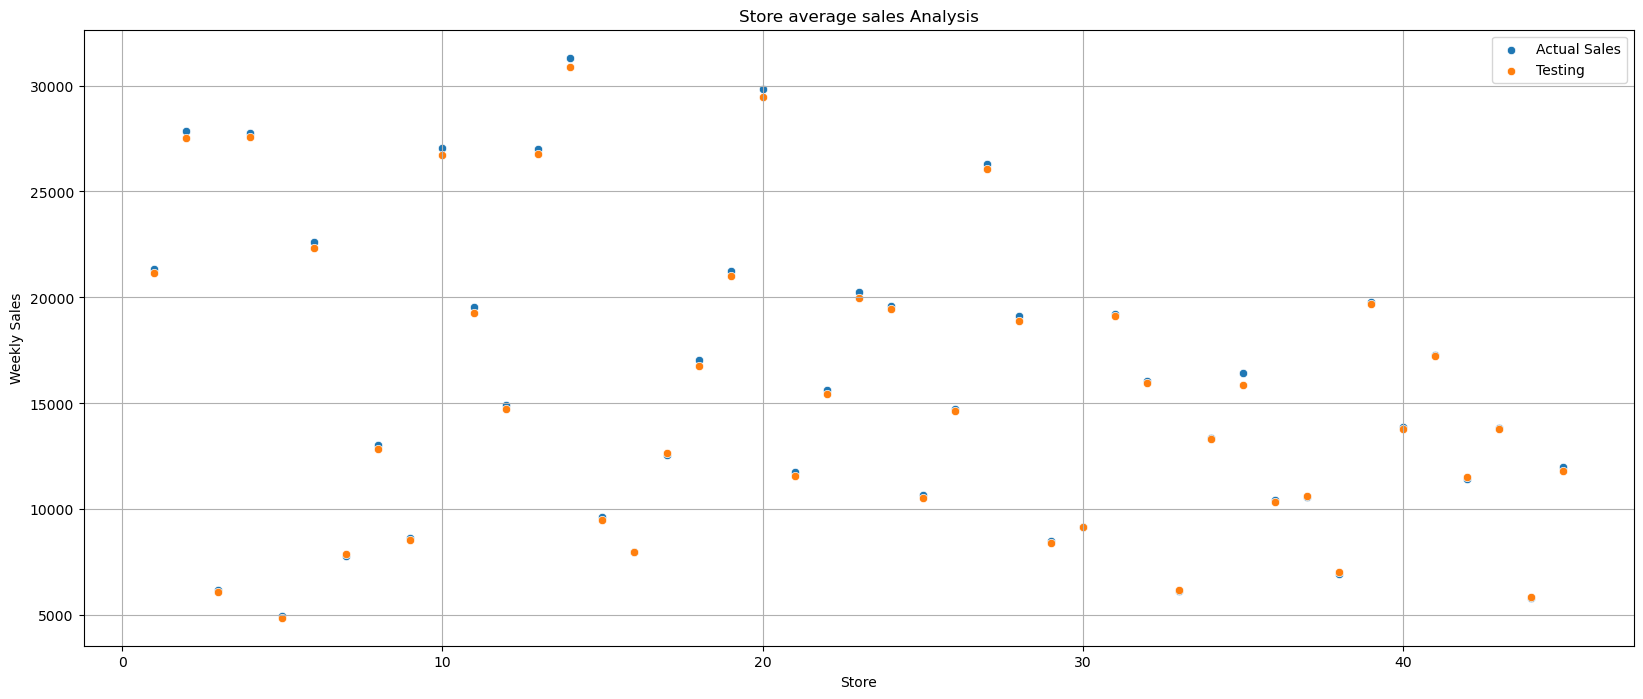

In [14]:
vldt1_grouped = vldt1.groupby(['Store'])[['weeklySales','y_vldt_pred']].mean()
train1_grouped = train1.groupby(['Store'])[['weeklySales','y_pred_1hot']].mean()
#print(vldt_grouped.head(5))

plt.figure(figsize=(20,8))

# Plot for Actual Sales in train_grouped
sns.scatterplot(x=vldt1_grouped.index, y=vldt1_grouped['weeklySales'], label='Actual Sales')

# Plot for Training (y_pred) in train_grouped
#sns.scatterplot(x=train1_grouped.index, y=train1_grouped['y_pred_1hot'], label='Training')

# Plot for Testing (y_vldt_pred) in vldt_grouped
sns.scatterplot(x=vldt1_grouped.index, y=vldt1_grouped['y_vldt_pred'], label='Testing')
#plt.xticks(np.arange(34875, 53, step=1))
plt.xlabel('Store')
plt.ylabel('Weekly Sales')
plt.title('Store average sales Analysis')
plt.grid()
plt

#Show average store sells prediction

<module 'matplotlib.pyplot' from '/Users/yorkie/anaconda3/envs/cisc684/lib/python3.11/site-packages/matplotlib/pyplot.py'>

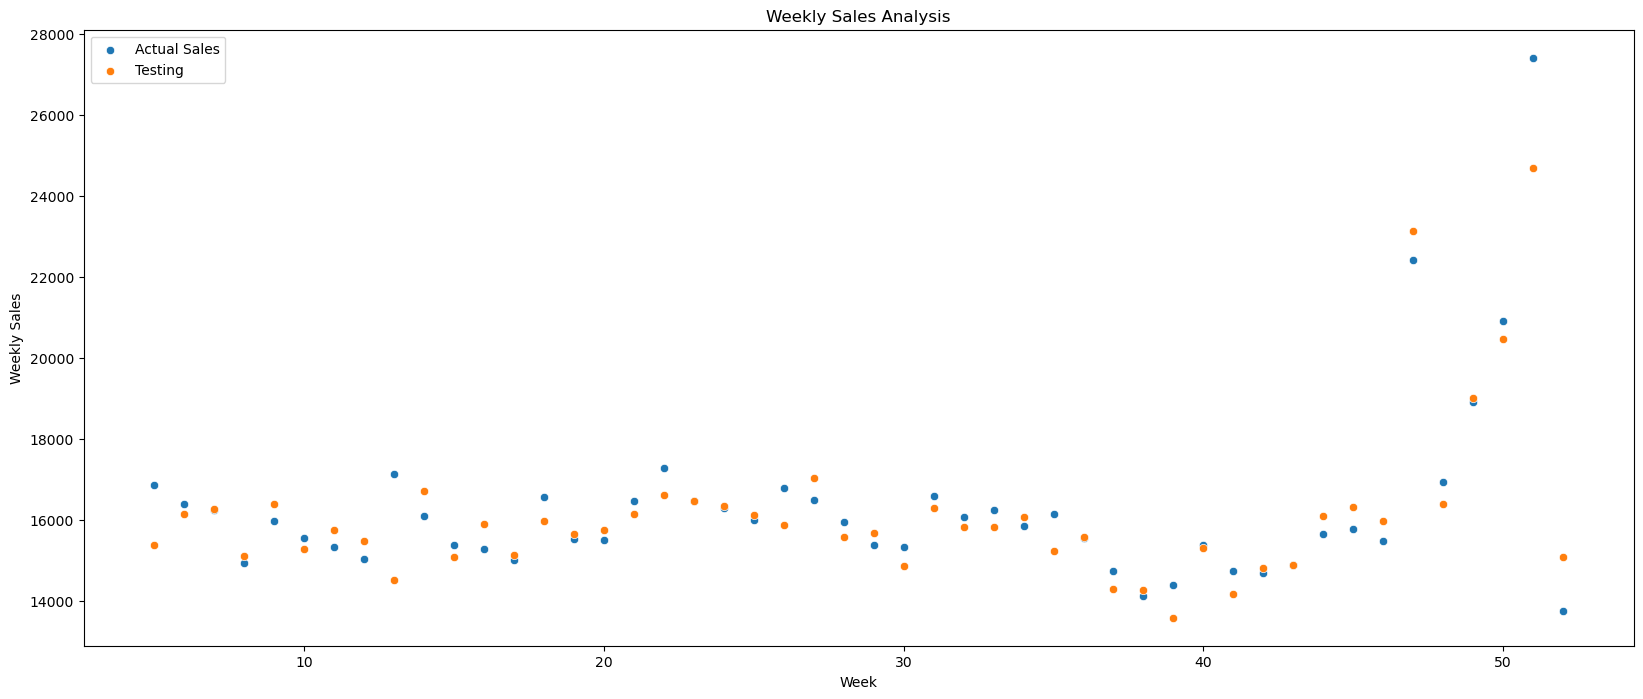

In [15]:
train1_grouped2 = train1.groupby(['Week'])[['weeklySales','y_pred_1hot']].mean()
#print(train_grouped.head(5))
vldt1_grouped2 = vldt1.groupby(['Week'])[['weeklySales','y_vldt_pred']].mean()
#print(vldt_grouped.head(5))


plt.figure(figsize=(20,8))
# Plot for Actual Sales in train_grouped
sns.scatterplot(x=vldt1_grouped2.index, y=vldt1_grouped2['weeklySales'], label='Actual Sales')

# Plot for Training (y_pred) in train_grouped
#sns.scatterplot(x=train1_grouped2.index, y=train1_grouped2['y_pred_1hot'], label='Training')

# Plot for Testing (y_vldt_pred) in vldt_grouped
sns.scatterplot(x=vldt1_grouped2.index, y=vldt1_grouped2['y_vldt_pred'], label='Testing')

# Setting the labels and title
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales Analysis')
plt.grid()

plt.grid()
#plt.xticks(np.arange(34875, 53, step=1))
plt

## Model 2: linear regression (Grouped customized features)

In [16]:
#df = train[columns[1:3, 206:208]]
df1 = train.loc[:, 'Dept_Group1_Ind':'MarkDown5_Ind']
df2 = train.loc[:, 'ThanksGiving_Ind':'Chistmas_3_Ind']
df3 = train.loc[:, 'Type_A':'Size_Group_Small']
df4 = train.loc[:, 'Temperature_norm':'Fuel_Price_norm']
X = np.concatenate((df1, df2, df3, df4), axis=1)
y = np.array(train['weeklySales'])

print(X.shape)
print(y.shape)

print(X.shape[1])

print(type(X))
print(type(y))

(264748, 22)
(264748,)
22
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [17]:
from sklearn import linear_model
reg_sklearn = linear_model.LinearRegression()
reg_sklearn.fit(X, y)

LinearRegression()

In [18]:
# Train the model
y_pred = reg_sklearn.predict(X)
train2 = train.copy()
train2['y_pred'] = y_pred
# Print training loss defined by the project requirment
print("Training error is: "+str(np.mean(np.absolute(train2['weeklySales']-train2['y_pred'])*train2['Holiday_loss'])))

Training error is: 14086.654959780148


In [19]:

df1 = vldt.loc[:, 'Dept_Group1_Ind':'MarkDown5_Ind']
df2 = vldt.loc[:, 'ThanksGiving_Ind':'Chistmas_3_Ind']
df3 = vldt.loc[:, 'Type_A':'Size_Group_Small']
df4 = vldt.loc[:, 'Temperature_norm':'Fuel_Price_norm']
X_vldt = np.concatenate((df1, df2, df3, df4), axis=1)
#Test the model
y_vldt_pred = reg_sklearn.predict(X_vldt)
vldt2 = vldt.copy()
vldt2['y_vldt_pred'] = y_vldt_pred

# Print testing loss defined by the project requirment
print("Testing error is: "+str(np.mean(np.absolute(vldt2['weeklySales']-vldt2['y_vldt_pred'])*vldt2['Holiday_loss'])))

Testing error is: 15335.752986029041


<module 'matplotlib.pyplot' from '/Users/yorkie/anaconda3/envs/cisc684/lib/python3.11/site-packages/matplotlib/pyplot.py'>

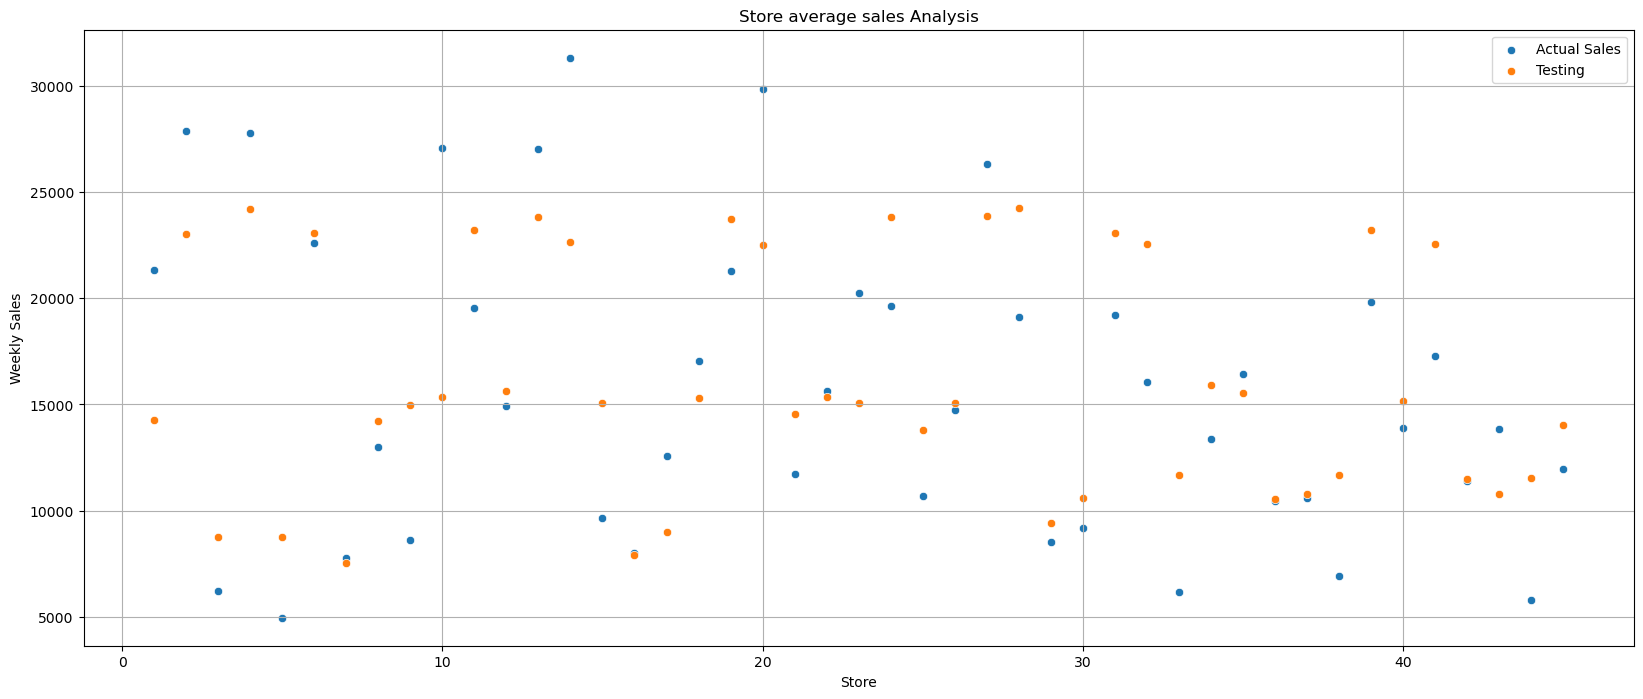

In [20]:
vldt2_grouped = vldt2.groupby(['Store'])[['weeklySales','y_vldt_pred']].mean()
train2_grouped = train2.groupby(['Store'])[['weeklySales','y_pred']].mean()
#print(vldt_grouped.head(5))

plt.figure(figsize=(20,8))

# Plot for Actual Sales in train_grouped
sns.scatterplot(x=vldt2_grouped.index, y=vldt2_grouped['weeklySales'], label='Actual Sales')

# Plot for Training (y_pred) in train_grouped
#sns.scatterplot(x=train2_grouped.index, y=train2_grouped['y_pred'], label='Training')

# Plot for Testing (y_vldt_pred) in vldt_grouped
sns.scatterplot(x=vldt2_grouped.index, y=vldt2_grouped['y_vldt_pred'], label='Testing')
#plt.xticks(np.arange(34875, 53, step=1))
plt.xlabel('Store')
plt.ylabel('Weekly Sales')
plt.title('Store average sales Analysis')
plt.grid()
plt

#Show average store sells prediction

<module 'matplotlib.pyplot' from '/Users/yorkie/anaconda3/envs/cisc684/lib/python3.11/site-packages/matplotlib/pyplot.py'>

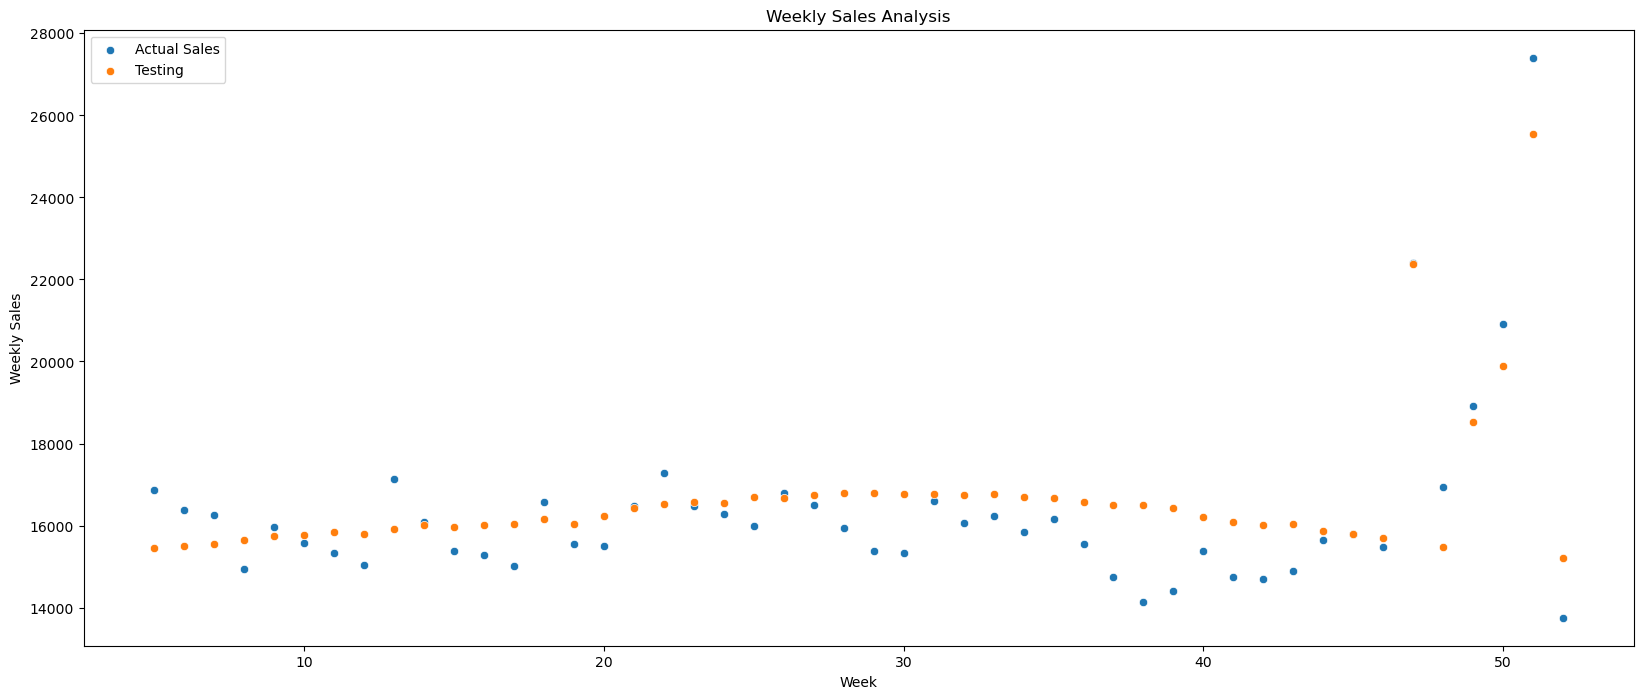

In [21]:
train2_grouped2 = train2.groupby(['Week'])[['weeklySales','y_pred']].mean()
#print(train_grouped.head(5))
vldt2_grouped2 = vldt2.groupby(['Week'])[['weeklySales','y_vldt_pred']].mean()
#print(vldt_grouped.head(5))


plt.figure(figsize=(20,8))
# Plot for Actual Sales in train_grouped
sns.scatterplot(x=vldt2_grouped2.index, y=vldt2_grouped2['weeklySales'], label='Actual Sales')

# Plot for Training (y_pred) in train_grouped
#sns.scatterplot(x=train2_grouped2.index, y=train2_grouped2['y_pred'], label='Training')

# Plot for Testing (y_vldt_pred) in vldt_grouped
sns.scatterplot(x=vldt2_grouped2.index, y=vldt2_grouped2['y_vldt_pred'], label='Testing')

# Setting the labels and title
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales Analysis')
plt.grid()

plt.grid()
#plt.xticks(np.arange(34875, 53, step=1))
plt

## Model 3: Linear Regression with customized loss function
The features are still based on the best we have so far which is one hot encoded feature.


In [71]:
print(train['Holiday_loss'])

48        1
49        1
50        1
51        1
52        1
         ..
421560    1
421561    1
421562    5
421563    1
421564    1
Name: Holiday_loss, Length: 264748, dtype: int64


In [68]:
# Modified homework model
class LinearReg:

    def __init__(self, learning_rate=0.01, epochs=10000, lmbda=0.0):
        self.epochs = epochs # number of epochs to train
        self.lr = learning_rate # learning rate - how fast the model should be updated
        self.w = None # the weights or coefficients
        self.b = None # the bias term
        self.lmbda = lmbda # regularization coefficient
        self.cost_list = [] # cost list for plotting

    def __initial_params(self, shape):
        #initialize weigth and bias as zeros

        #### START CODE HERE (~2 line) ####
        self.w = np.zeros(shape)
        self.b = 0

        #### END CODE HERE ####

    def __predictions(self, X):
        return np.dot(X, self.w) + self.b

    def __calculate_cost(self, error):

        return np.mean(np.absolute(error)*train['Holiday_loss'])


    def __gradient_descent(self, X, y, y_pred):
        # difference between prediction and actual
        error = y_pred - y

        # calculate cost and append them to list
        cost = self.__calculate_cost(error)
        self.cost_list.append(cost)

        # Calculate gradients
        # Return:
        # dw -- gradient of the loss with respect to w, thus same shape as w
        # db -- gradient of the loss with respect to b, thus same shape as b

        ### START CODE HERE ### (≈ 3 lines of code)
        self.dw = np.matmul(X.T, error)/X.shape[0] + self.lmbda * self.w
        self.db = np.sum(error)/X.shape[0] + self.lmbda * self.b
        return self.dw, self.db
        ### END CODE HERE ###

    def __update_parameters(self, dw, db):
        #update weight and bias with gradients
        self.w -= self.lr * dw
        self.b -= self.lr * db

        return True

    def fit(self, X, y):
        """fits the model"""
        self.__initial_params(X.shape[1])
        for _ in range(self.epochs):
            y_pred = self.__predictions(X)
            dw, db,  = self.__gradient_descent(X, y, y_pred)
            self.__update_parameters(dw, db)
        return True

    def predict(self, X):
        return self.__predictions(X)

    def calculate_rmse(self, y_real, y_pred):
        """returns root mean square error"""

        ### START CODE HERE ### (≈ 1 lines of code)
        return np.sqrt(sum((y_real-y_pred)**2)/(2*X.shape[0]))
        ### END CODE HERE ###

    def get_params(self):
        return self.w, self.b

    def plot_cost(self):
        """plots the progress of cost on each iteration"""
        plt.title('Customized loss function')
        plt.xlabel('No. of iterations')
        plt.ylabel('Loss')
        plt.plot(self.cost_list)
        plt.show()

    def calculate_r2(self, X, y):
        """returns r2"""
        sum_squares = 0
        sum_residuals = 0
        y_mean = np.mean(y)
        for i in range(X.shape[0]):
            y_pred = self.__predictions(X[i])
            sum_squares += (y[i] - y_mean) ** 2
            sum_residuals += (y[i] - y_pred) ** 2
        score = 1- (sum_residuals / sum_squares)
        return score


In [98]:
#df = train[columns[1:3, 206:208]]
df1 = train.loc[:, 'Store_1':'Type_C']
df2 = train.loc[:, 'Size_norm':'Size_norm']
df3 = train.loc[:, 'Temperature_norm':'Unemployment_norm']
df4 = train.loc[:, 'MarkDown1_Ind':'Holiday_Ind']
df5 = train.loc[:,'weeklySales_5':'weeklySales_1']
X = np.concatenate((df1, df2, df3, df4, df5), axis=1)
y = np.array(train['weeklySales'])

print(X.shape)
print(y.shape)

print(X.shape[1])

print(type(X))
print(type(y))

(264748, 197)
(264748,)
197
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [102]:
reg = LinearReg(learning_rate=0.1,epochs=5000, lmbda=0.0)
reg.fit(X, y) # fit/train the model

# get predictions
y_pred = reg.predict(X)
train3 = train.copy()
train3['y_pred'] = y_pred

print("Training error is: "+str(np.mean(np.absolute(train3['weeklySales']-train3['y_pred'])*train3['Holiday_loss'])))

Training error is: 0.009818414811319218


In [103]:

### Reverse scaling and calculate actual loss

y_pred = y_pred*(max_value - min_value) + min_value


train3 = train.copy()
train3['weeklySales'] = train3['weeklySales']*(max_value - min_value) + min_value


train3['y_pred'] = y_pred

print("Training error is: "+str(np.mean(np.absolute(train3['weeklySales']-train3['y_pred'])*train3['Holiday_loss'])))

Training error is: 6854.120504328651


In [77]:

print(y_pred)
#train3 = train.copy()
#train3['y_pred'] = y_pred

#print("Training error is: "+str(np.mean(np.absolute(train3['weeklySales']-train3['y_pred'])*train3['Holiday_loss'])))

[nan nan nan ... nan nan nan]


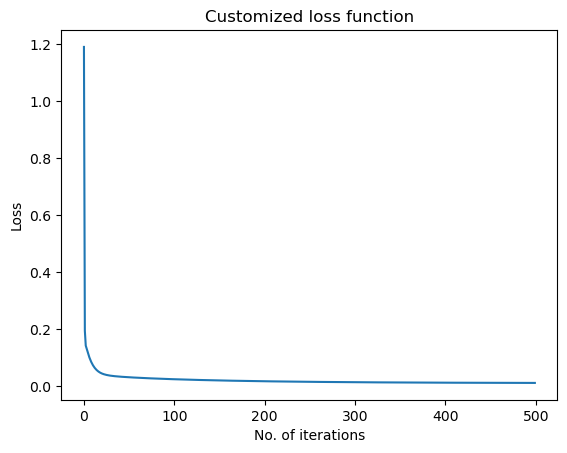

In [101]:
reg.plot_cost()

In [104]:
#df = train[columns[1:3, 206:208]]
df1 = vldt.loc[:, 'Store_1':'Type_C']
df2 = vldt.loc[:, 'Size_norm':'Size_norm']
df3 = vldt.loc[:, 'Temperature_norm':'Unemployment_norm']
df4 = vldt.loc[:, 'MarkDown1_Ind':'Holiday_Ind']
df5 = vldt.loc[:,'weeklySales_5':'weeklySales_1']
X_vldt = np.concatenate((df1, df2, df3, df4, df5), axis=1)
y_vldt = np.array(vldt['weeklySales'])

y_vldt_pred = reg.predict(X_vldt)*(max_value - min_value) + min_value
vldt3 = vldt.copy()
vldt3['weeklySales'] = vldt3['weeklySales']*(max_value - min_value) + min_value
vldt3['y_vldt_pred'] = y_vldt_pred
print("Testing error is: "+str(np.mean(np.absolute(vldt3['weeklySales']-vldt3['y_vldt_pred'])*vldt3['Holiday_loss'])))


Testing error is: 8535.304223128169


<module 'matplotlib.pyplot' from '/Users/yorkie/anaconda3/envs/cisc684/lib/python3.11/site-packages/matplotlib/pyplot.py'>

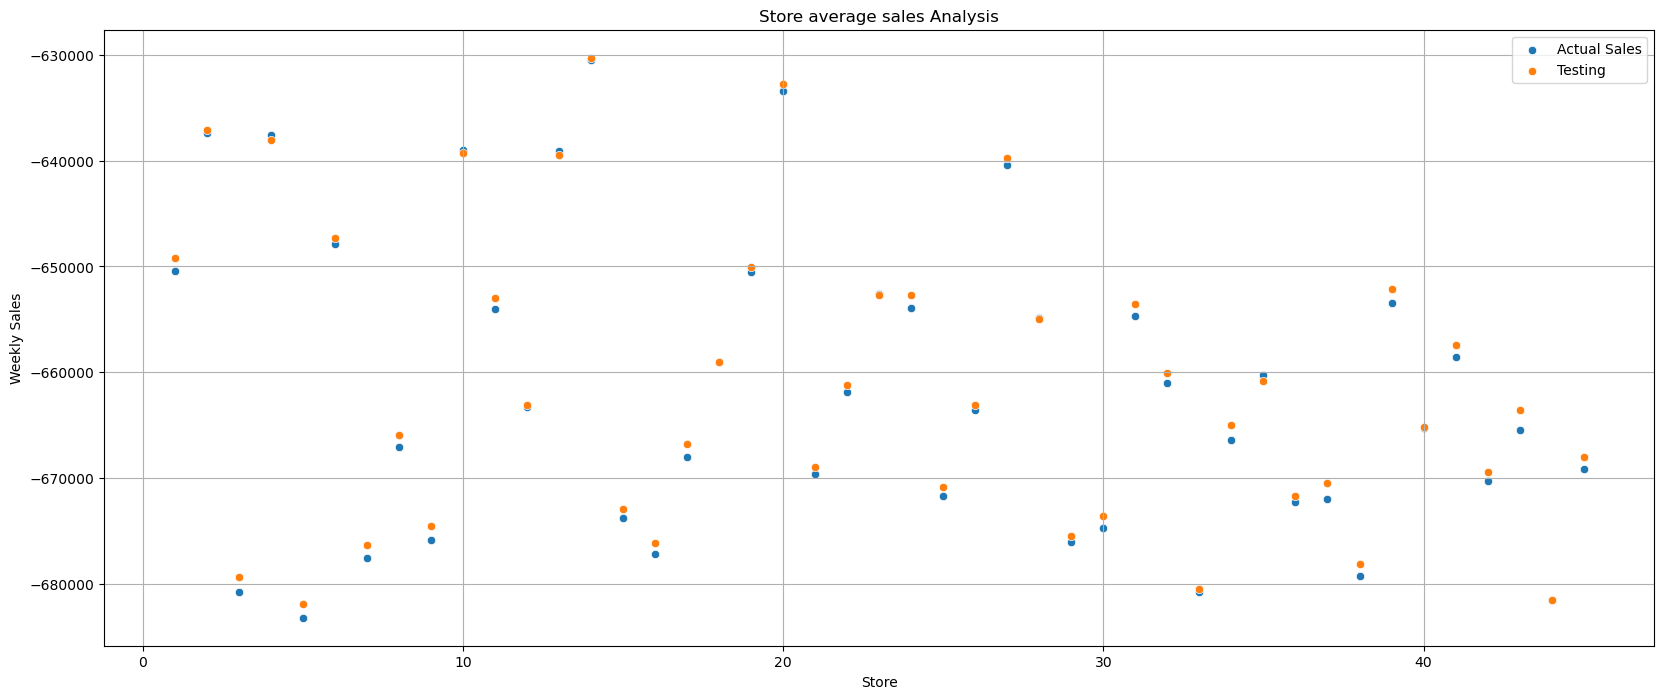

In [105]:
vldt3_grouped = vldt3.groupby(['Store'])[['weeklySales','y_vldt_pred']].mean()
train3_grouped = train3.groupby(['Store'])[['weeklySales','y_pred']].mean()
#print(vldt_grouped.head(5))

plt.figure(figsize=(20,8))

# Plot for Actual Sales in train_grouped
sns.scatterplot(x=vldt3_grouped.index, y=vldt3_grouped['weeklySales'], label='Actual Sales')

# Plot for Training (y_pred) in train_grouped
#sns.scatterplot(x=train3_grouped.index, y=train3_grouped['y_pred'], label='Training')

# Plot for Testing (y_vldt_pred) in vldt_grouped
sns.scatterplot(x=vldt3_grouped.index, y=vldt3_grouped['y_vldt_pred'], label='Testing')
#plt.xticks(np.arange(34875, 53, step=1))
plt.xlabel('Store')
plt.ylabel('Weekly Sales')
plt.title('Store average sales Analysis')
plt.grid()
plt

#Show average store sells prediction

<module 'matplotlib.pyplot' from '/Users/yorkie/anaconda3/envs/cisc684/lib/python3.11/site-packages/matplotlib/pyplot.py'>

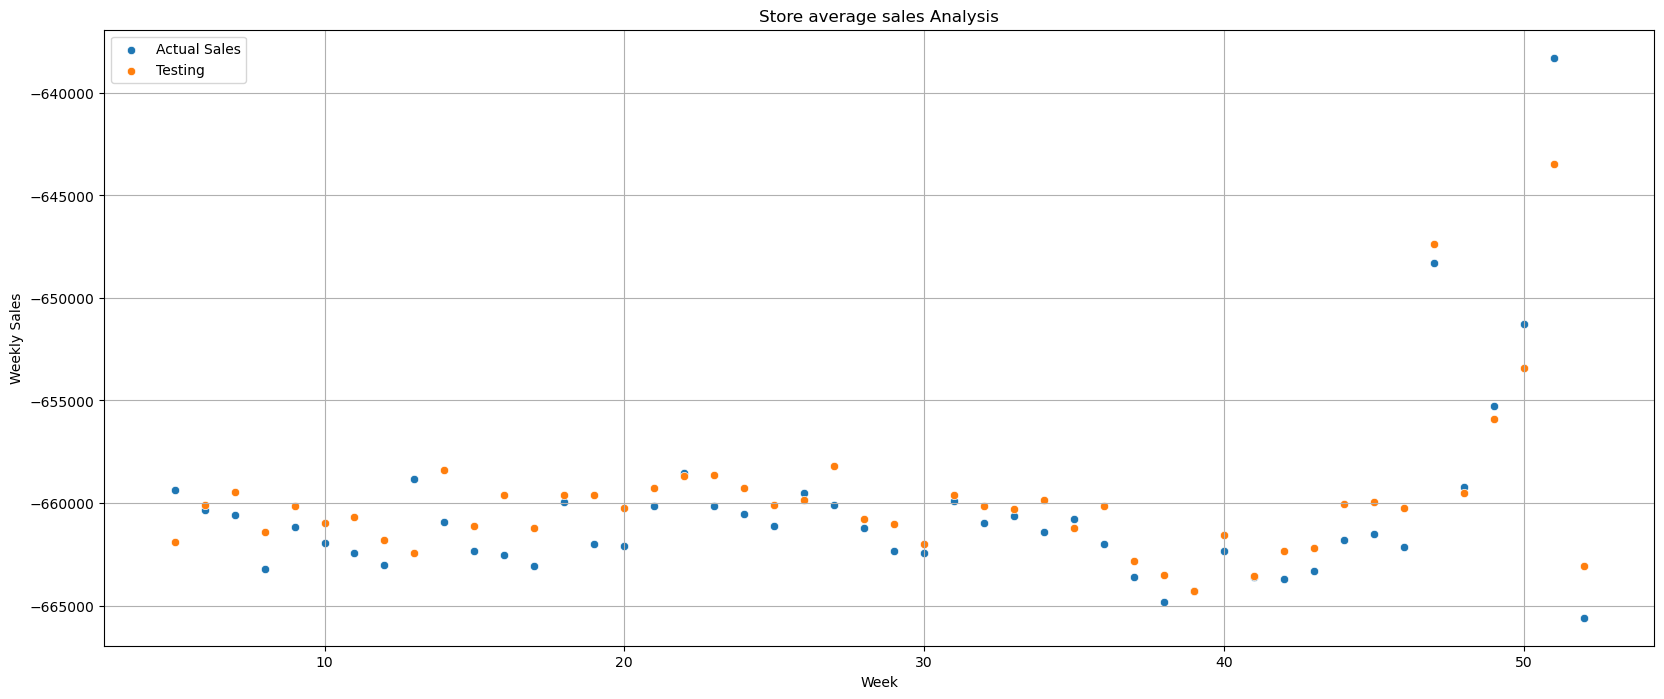

In [106]:
vldt3_grouped2 = vldt3.groupby(['Week'])[['weeklySales','y_vldt_pred']].mean()
train3_grouped2 = train3.groupby(['Week'])[['weeklySales','y_pred']].mean()
#print(vldt_grouped.head(5))

plt.figure(figsize=(20,8))

# Plot for Actual Sales in train_grouped
sns.scatterplot(x=vldt3_grouped2.index, y=vldt3_grouped2['weeklySales'], label='Actual Sales')

# Plot for Training (y_pred) in train_grouped
#sns.scatterplot(x=train3_grouped2.index, y=train3_grouped2['y_pred'], label='Training')

# Plot for Testing (y_vldt_pred) in vldt_grouped
sns.scatterplot(x=vldt3_grouped2.index, y=vldt3_grouped2['y_vldt_pred'], label='Testing')
#plt.xticks(np.arange(34875, 53, step=1))
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.title('Store average sales Analysis')
plt.grid()
plt

#Show average store sells prediction

## Model 4: RNN LSTM (autoregression)

In [9]:
# split to training dataset and validation dataset for RNN
raw_train = pd.get_dummies(raw, columns=['Store', 'Dept', 'Week', 'Type','Size_Group'])
raw_train['Store'] = raw['Store']
raw_train['Dept'] = raw['Dept']
raw_train['Week'] = raw['Week']
raw_train['Type'] = raw['Type']


raw_train_sorted = raw_train.sort_values(by=['Store', 'Dept', 'Date'], ascending=[True, True, False])
#print(raw_train_sorted)
#print(raw_train_sorted[0:10])

#train_w_na = raw_train_sorted[(raw_train_sorted['Year'] > 2010) & (raw_train_sorted['Date'] <= '2012-09-21')]
train = raw_train_sorted[raw_train_sorted['Year'] > 2010 ].dropna(subset=['weeklySales_5','weeklySales_4','weeklySales_3','weeklySales_2','weeklySales_1'])
#train = raw_train_sorted[raw_train_sorted['Year'] == 2011]

vldt = raw_train_sorted[raw_train_sorted['Year'] == 2010].dropna(subset=['weeklySales_5','weeklySales_4','weeklySales_3','weeklySales_2','weeklySales_1'])
print(vldt[0:10])


#print(train.head(5))

#pd.DataFrame(train.dtypes, columns=['Type'])

         Date  weeklySales  isHoliday  weeklySales_5  weeklySales_4  \
47 2010-12-31    -0.930916       True      -0.923635      -0.932816   
46 2010-12-24    -0.825466      False      -0.932816      -0.936024   
45 2010-12-17    -0.857033      False      -0.936024      -0.935972   
44 2010-12-10    -0.895467      False      -0.935972      -0.939913   
43 2010-12-03    -0.921195      False      -0.939913      -0.930916   
42 2010-11-26    -0.931787       True      -0.930916      -0.825466   
41 2010-11-19    -0.929689      False      -0.825466      -0.857033   
40 2010-11-12    -0.929698      False      -0.857033      -0.895467   
39 2010-11-05    -0.887614      False      -0.895467      -0.921195   
38 2010-10-29    -0.875002      False      -0.921195      -0.931787   

    weeklySales_3  weeklySales_2  weeklySales_1    Size  Size_norm  ...  \
47      -0.936024      -0.935972      -0.939913  151315   0.630267  ...   
46      -0.935972      -0.939913      -0.930916  151315   0.630267  

In [10]:
x_train = train.loc[:, 'weeklySales_5':'weeklySales_1']
y_train = train['weeklySales']

x_vldt = vldt.loc[:, 'weeklySales_5':'weeklySales_1']
y_vldt = vldt['weeklySales']

x_train = np.array(x_train)
x_vldt = np.array(x_vldt)
y_train = np.array(y_train)
y_vldt = np.array(y_vldt)

x_train = torch.tensor(x_train).unsqueeze(2).float()
x_vldt = torch.tensor(x_vldt).unsqueeze(2).float()
y_train = torch.tensor(y_train).unsqueeze(1).float()
y_vldt = torch.tensor(y_vldt).unsqueeze(1).float()

print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_vldt.shape = ', x_vldt.shape)
print('y_vldt.shape = ', y_vldt.shape)
# Check for NaN values
nan_mask = torch.isnan(x_train)
#print("NaN values:", nan_mask)
print(sum(nan_mask))

# Check for infinite values
inf_mask = torch.isinf(x_train)
#print("Infinite values:", inf_mask)
print(sum(inf_mask))

x_train.shape =  torch.Size([264748, 5, 1])
y_train.shape =  torch.Size([264748, 1])
x_vldt.shape =  torch.Size([140461, 5, 1])
y_vldt.shape =  torch.Size([140461, 1])
tensor([[0],
        [0],
        [0],
        [0],
        [0]])
tensor([[0],
        [0],
        [0],
        [0],
        [0]])


In [117]:
print('x_train = ', x_train)
print('y_train = ', y_train)
print('x_vldt = ', x_vldt)
print('y_vldt = ', y_vldt)

x_train =  tensor([[[-0.9072],
         [-0.9164],
         [-0.9205],
         [-0.9230],
         [-0.9314]],

        [[-0.9164],
         [-0.9205],
         [-0.9230],
         [-0.9314],
         [-0.9306]],

        [[-0.9205],
         [-0.9230],
         [-0.9314],
         [-0.9306],
         [-0.9295]],

        ...,

        [[-0.9838],
         [-0.9849],
         [-0.9846],
         [-0.9855],
         [-0.9855]],

        [[-0.9849],
         [-0.9846],
         [-0.9855],
         [-0.9855],
         [-0.9857]],

        [[-0.9846],
         [-0.9855],
         [-0.9855],
         [-0.9857],
         [-0.9856]]])
y_train =  tensor([[-0.9306],
        [-0.9295],
        [-0.9332],
        ...,
        [-0.9857],
        [-0.9856],
        [-0.9854]])
x_vldt =  tensor([[[-0.9236],
         [-0.9328],
         [-0.9360],
         [-0.9360],
         [-0.9399]],

        [[-0.9328],
         [-0.9360],
         [-0.9360],
         [-0.9399],
         [-0.9309]],

        [[

In [25]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True).to(device)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :])
        return out
    

In [23]:
input_dim = 1
hidden_dim = 64
num_layers = 1
output_dim = 1
num_epochs = 500
learning_rate = 0.01
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cpu


In [26]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)
#criterion = torch.nn.MSELoss(reduction='mean')
criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [27]:
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.9286842942237854
Epoch  1 MSE:  0.5108352303504944
Epoch  2 MSE:  0.18581755459308624
Epoch  3 MSE:  0.003172469325363636
Epoch  4 MSE:  0.2009432464838028
Epoch  5 MSE:  0.10669895261526108
Epoch  6 MSE:  0.007881589233875275
Epoch  7 MSE:  0.015233072452247143
Epoch  8 MSE:  0.05575338378548622
Epoch  9 MSE:  0.07804928719997406
Epoch  10 MSE:  0.07305260747671127
Epoch  11 MSE:  0.04979817569255829
Epoch  12 MSE:  0.02225521020591259
Epoch  13 MSE:  0.00411455612629652
Epoch  14 MSE:  0.003993089310824871
Epoch  15 MSE:  0.01839841902256012
Epoch  16 MSE:  0.030493253841996193
Epoch  17 MSE:  0.028875647112727165
Epoch  18 MSE:  0.0175637099891901
Epoch  19 MSE:  0.006574118975549936
Epoch  20 MSE:  0.0018193746218457818
Epoch  21 MSE:  0.0032432852312922478
Epoch  22 MSE:  0.007661578711122274
Epoch  23 MSE:  0.011678321287035942
Epoch  24 MSE:  0.013208189979195595
Epoch  25 MSE:  0.011832868680357933
Epoch  26 MSE:  0.008478936739265919
Epoch  27 MSE:  0.00476643

Epoch  216 MSE:  0.0006595389568246901
Epoch  217 MSE:  0.0006526412907987833
Epoch  218 MSE:  0.0006457503768615425
Epoch  219 MSE:  0.0006388668552972376
Epoch  220 MSE:  0.0006319917156361043
Epoch  221 MSE:  0.0006251257145777345
Epoch  222 MSE:  0.0006182700162753463
Epoch  223 MSE:  0.0006114254356361926
Epoch  224 MSE:  0.0006045929621905088
Epoch  225 MSE:  0.0005977735272608697
Epoch  226 MSE:  0.0005909684114158154
Epoch  227 MSE:  0.0005841785459779203
Epoch  228 MSE:  0.0005774050951004028
Epoch  229 MSE:  0.0005706492229364812
Epoch  230 MSE:  0.0005639123846776783
Epoch  231 MSE:  0.0005571959773078561
Epoch  232 MSE:  0.0005505012231878936
Epoch  233 MSE:  0.0005438298103399575
Epoch  234 MSE:  0.0005371830775402486
Epoch  235 MSE:  0.0005305624799802899
Epoch  236 MSE:  0.0005239699967205524
Epoch  237 MSE:  0.000517407082952559
Epoch  238 MSE:  0.0005108757177367806
Epoch  239 MSE:  0.0005043778801336884
Epoch  240 MSE:  0.0004979153745807707
Epoch  241 MSE:  0.0004914

Epoch  424 MSE:  0.0002704394282773137
Epoch  425 MSE:  0.00027043247246183455
Epoch  426 MSE:  0.00027042560395784676
Epoch  427 MSE:  0.0002704187063500285
Epoch  428 MSE:  0.0002704117214307189
Epoch  429 MSE:  0.00027040482382290065
Epoch  430 MSE:  0.0002703978680074215
Epoch  431 MSE:  0.0002703909412957728
Epoch  432 MSE:  0.00027038398548029363
Epoch  433 MSE:  0.00027037705876864493
Epoch  434 MSE:  0.0002703701320569962
Epoch  435 MSE:  0.00027036317624151707
Epoch  436 MSE:  0.00027035624952986836
Epoch  437 MSE:  0.0002703492937143892
Epoch  438 MSE:  0.0002703423670027405
Epoch  439 MSE:  0.00027033541118726134
Epoch  440 MSE:  0.00027032848447561264
Epoch  441 MSE:  0.0002703215286601335
Epoch  442 MSE:  0.0002703146019484848
Epoch  443 MSE:  0.00027030761702917516
Epoch  444 MSE:  0.00027030069031752646
Epoch  445 MSE:  0.0002702937345020473
Epoch  446 MSE:  0.0002702867495827377
Epoch  447 MSE:  0.0002702797937672585
Epoch  448 MSE:  0.0002702728670556098
Epoch  449 MSE

In [28]:
predict = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
original = scaler.inverse_transform(y_train.detach().cpu().numpy())

train4 = train.copy()
train4['y_pred'] = predict
train4['weeklySales'] = original
print(np.mean(np.absolute(train4['weeklySales']-train4['y_pred'])*train4['Holiday_loss']))

2874.390618244844


In [29]:
# make predictions
with torch.no_grad():
    x_vldt = x_vldt.to(device)
    y_vldt_pred = model(x_vldt)


predict_vldt = scaler.inverse_transform(y_vldt_pred.detach().cpu().numpy())
original_vldt = scaler.inverse_transform(y_vldt.detach().cpu().numpy())
vldt4 = vldt.copy()
vldt4['y_vldt_pred'] = predict_vldt
vldt4['weeklySales'] = original_vldt

print(np.mean(np.absolute(vldt4['weeklySales']-vldt4['y_vldt_pred'])*vldt4['Holiday_loss']))

3494.336256427387


<module 'matplotlib.pyplot' from '/Users/yorkie/anaconda3/envs/cisc684/lib/python3.11/site-packages/matplotlib/pyplot.py'>

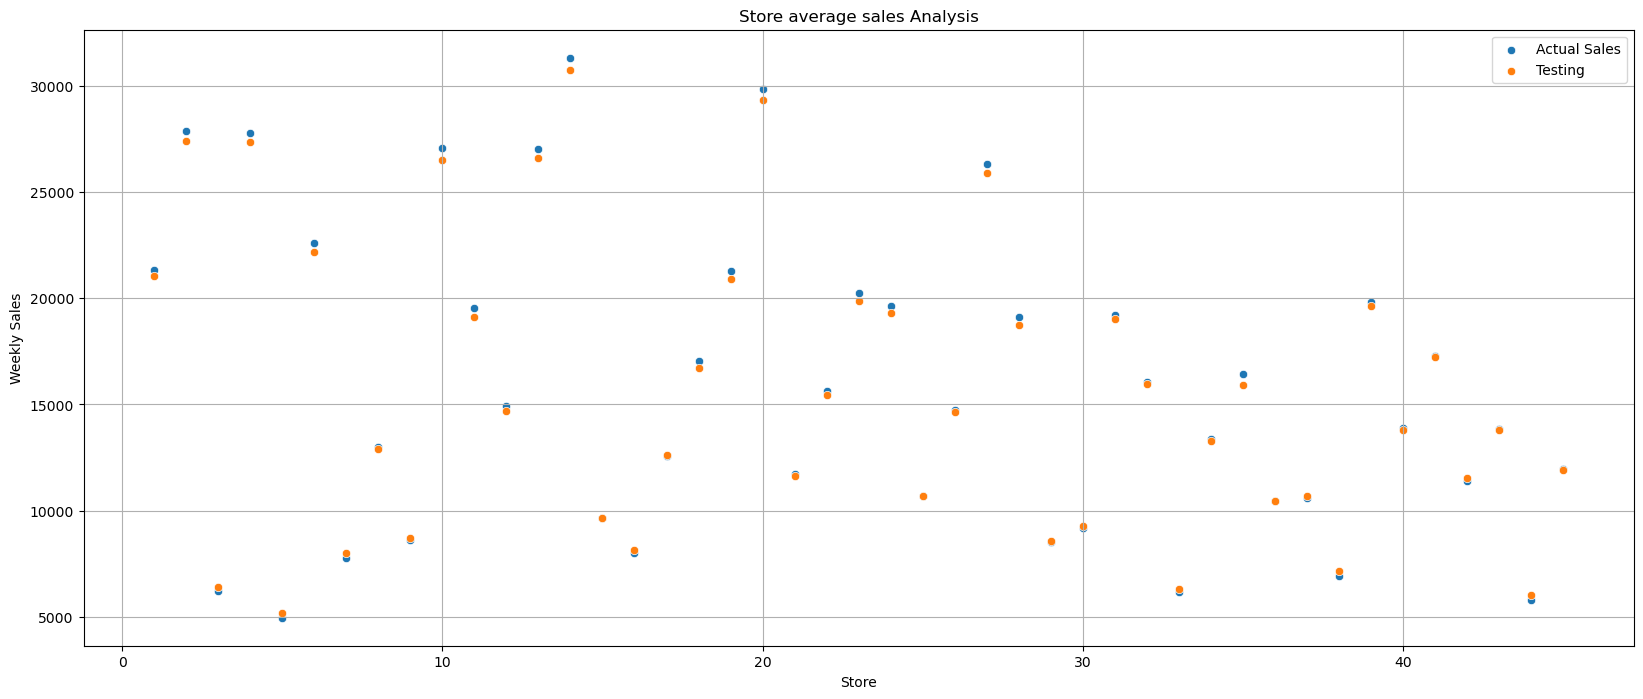

In [30]:
vldt4_grouped = vldt4.groupby(['Store'])[['weeklySales','y_vldt_pred']].mean()
train4_grouped = train4.groupby(['Store'])[['weeklySales','y_pred']].mean()
#print(vldt_grouped.head(5))

plt.figure(figsize=(20,8))

# Plot for Actual Sales in train_grouped
sns.scatterplot(x=vldt4_grouped.index, y=vldt4_grouped['weeklySales'], label='Actual Sales')

# Plot for Training (y_pred) in train_grouped
#sns.scatterplot(x=train4_grouped.index, y=train4_grouped['y_pred'], label='Training')

# Plot for Testing (y_vldt_pred) in vldt_grouped
sns.scatterplot(x=vldt4_grouped.index, y=vldt4_grouped['y_vldt_pred'], label='Testing')
#plt.xticks(np.arange(34875, 53, step=1))
plt.xlabel('Store')
plt.ylabel('Weekly Sales')
plt.title('Store average sales Analysis')
plt.grid()
plt

#Show average store sells prediction

<module 'matplotlib.pyplot' from '/Users/yorkie/anaconda3/envs/cisc684/lib/python3.11/site-packages/matplotlib/pyplot.py'>

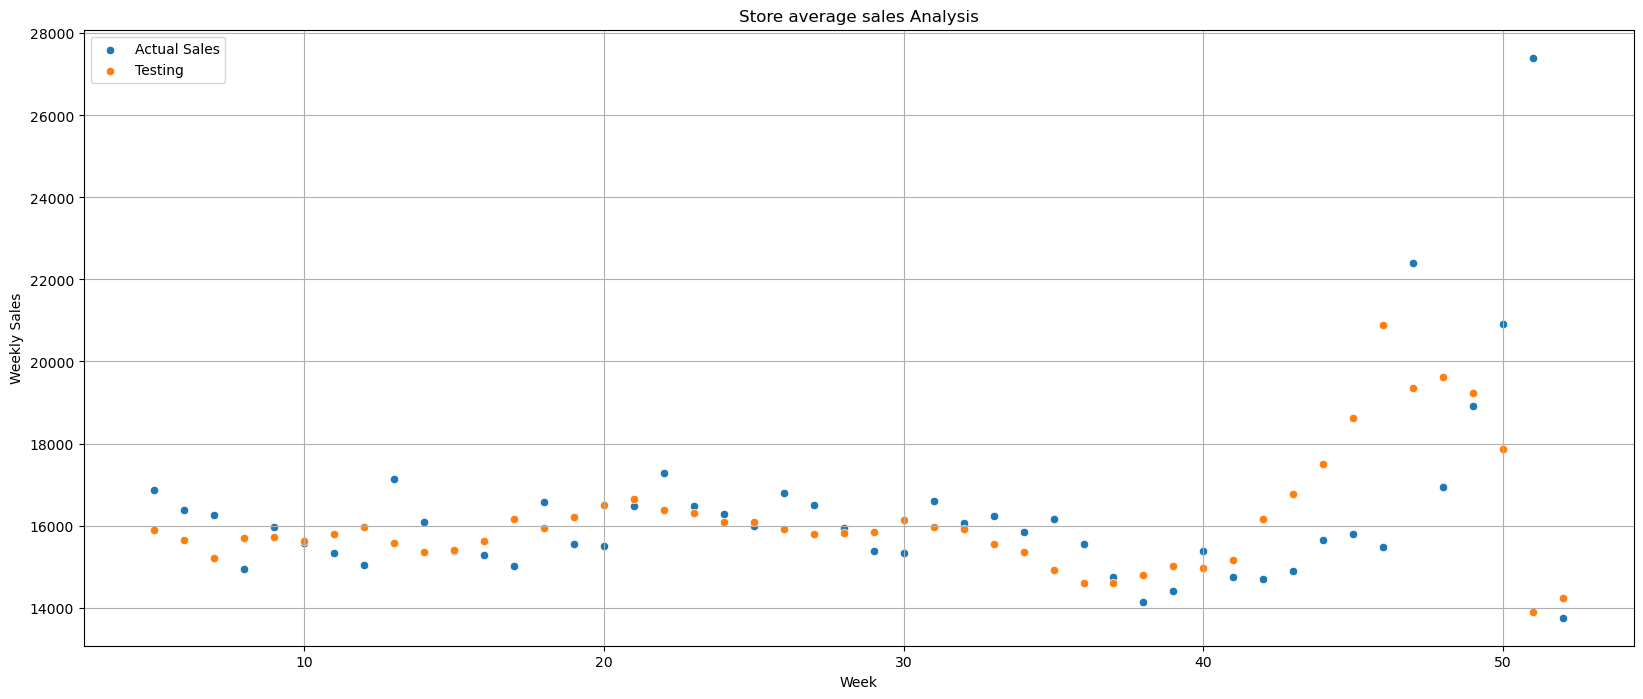

In [31]:
vldt4_grouped2 = vldt4.groupby(['Week'])[['weeklySales','y_vldt_pred']].mean()
train4_grouped2 = train4.groupby(['Week'])[['weeklySales','y_pred']].mean()
#print(vldt_grouped.head(5))

plt.figure(figsize=(20,8))

# Plot for Actual Sales in train_grouped
sns.scatterplot(x=vldt4_grouped2.index, y=vldt4_grouped2['weeklySales'], label='Actual Sales')

# Plot for Training (y_pred) in train_grouped
#sns.scatterplot(x=train4_grouped2.index, y=train4_grouped2['y_pred'], label='Training')

# Plot for Testing (y_vldt_pred) in vldt_grouped
sns.scatterplot(x=vldt4_grouped2.index, y=vldt4_grouped2['y_vldt_pred'], label='Testing')
#plt.xticks(np.arange(34875, 53, step=1))
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.title('Store average sales Analysis')
plt.grid()
plt

#Show average store sells prediction

## Model 5: GRU with lost customized loss function

In [32]:
# Convert Pandas Series to NumPy array
holiday_loss_array = train['Holiday_loss'].to_numpy()

# Convert NumPy array to PyTorch tensor
holiday_loss_tensor = torch.tensor(holiday_loss_array).unsqueeze(1).float().to(device)

print(holiday_loss_tensor)


tensor([[1.],
        [1.],
        [5.],
        ...,
        [1.],
        [1.],
        [1.]])


In [33]:
def custom_loss(output, target, holiday_loss_tensor):
    return torch.mean(torch.abs(output - target) * holiday_loss_tensor)


In [34]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [35]:
input_dim = 1
hidden_dim = 64
num_layers = 1
output_dim = 1
num_epochs = 500
learning_rate = 0.01
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [36]:
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    y_train_pred = model(x_train)
    loss = custom_loss(y_train_pred, y_train, holiday_loss_tensor)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.9888045787811279
Epoch  1 MSE:  0.7116596698760986
Epoch  2 MSE:  0.35348108410835266
Epoch  3 MSE:  0.2080763429403305
Epoch  4 MSE:  0.15314726531505585
Epoch  5 MSE:  0.10781948268413544
Epoch  6 MSE:  0.14978960156440735
Epoch  7 MSE:  0.08611150830984116
Epoch  8 MSE:  0.08439361304044724
Epoch  9 MSE:  0.09686247259378433
Epoch  10 MSE:  0.03532348573207855
Epoch  11 MSE:  0.06107389181852341
Epoch  12 MSE:  0.04869654402136803
Epoch  13 MSE:  0.04214391112327576
Epoch  14 MSE:  0.03204988315701485
Epoch  15 MSE:  0.03574952110648155
Epoch  16 MSE:  0.03264344483613968
Epoch  17 MSE:  0.036498311907052994
Epoch  18 MSE:  0.035070933401584625
Epoch  19 MSE:  0.036811713129282
Epoch  20 MSE:  0.03151818737387657
Epoch  21 MSE:  0.04005756974220276
Epoch  22 MSE:  0.04138227924704552
Epoch  23 MSE:  0.04794175177812576
Epoch  24 MSE:  0.03349621593952179
Epoch  25 MSE:  0.05322904884815216
Epoch  26 MSE:  0.032180219888687134
Epoch  27 MSE:  0.04244915395975113
Epoc

Epoch  223 MSE:  0.029259830713272095
Epoch  224 MSE:  0.02404779940843582
Epoch  225 MSE:  0.022109268233180046
Epoch  226 MSE:  0.014130307361483574
Epoch  227 MSE:  0.022531980648636818
Epoch  228 MSE:  0.01824413798749447
Epoch  229 MSE:  0.02517213486135006
Epoch  230 MSE:  0.012978176586329937
Epoch  231 MSE:  0.020559169352054596
Epoch  232 MSE:  0.01441119983792305
Epoch  233 MSE:  0.028779832646250725
Epoch  234 MSE:  0.012330369092524052
Epoch  235 MSE:  0.026381101459264755
Epoch  236 MSE:  0.01964912936091423
Epoch  237 MSE:  0.029024312272667885
Epoch  238 MSE:  0.01976691000163555
Epoch  239 MSE:  0.03760425001382828
Epoch  240 MSE:  0.043205395340919495
Epoch  241 MSE:  0.014018150046467781
Epoch  242 MSE:  0.0553758330643177
Epoch  243 MSE:  0.060842253267765045
Epoch  244 MSE:  0.019143011420965195
Epoch  245 MSE:  0.06414053589105606
Epoch  246 MSE:  0.09178727865219116
Epoch  247 MSE:  0.07587415724992752
Epoch  248 MSE:  0.025065621361136436
Epoch  249 MSE:  0.06580

Epoch  442 MSE:  0.017809968441724777
Epoch  443 MSE:  0.009950713254511356
Epoch  444 MSE:  0.008326784707605839
Epoch  445 MSE:  0.012027918361127377
Epoch  446 MSE:  0.015603430569171906
Epoch  447 MSE:  0.00950236339122057
Epoch  448 MSE:  0.008865194395184517
Epoch  449 MSE:  0.016037559136748314
Epoch  450 MSE:  0.009473626501858234
Epoch  451 MSE:  0.010763858444988728
Epoch  452 MSE:  0.013351183384656906
Epoch  453 MSE:  0.012673744931817055
Epoch  454 MSE:  0.008399061858654022
Epoch  455 MSE:  0.008670884184539318
Epoch  456 MSE:  0.011901989579200745
Epoch  457 MSE:  0.01717957854270935
Epoch  458 MSE:  0.010114342905580997
Epoch  459 MSE:  0.026991404592990875
Epoch  460 MSE:  0.019180437549948692
Epoch  461 MSE:  0.025754189118742943
Epoch  462 MSE:  0.0294792540371418
Epoch  463 MSE:  0.00873365718871355
Epoch  464 MSE:  0.03552098944783211
Epoch  465 MSE:  0.031598836183547974
Epoch  466 MSE:  0.012800708413124084
Epoch  467 MSE:  0.020750174298882484
Epoch  468 MSE:  0

In [37]:
predict = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
original = scaler.inverse_transform(y_train.detach().cpu().numpy())

train5 = train.copy()
train5['y_pred'] = predict
train5['weeklySales'] = original
print(np.mean(np.absolute(train5['weeklySales']-train5['y_pred'])*train5['Holiday_loss']))

5588.490497973091


In [38]:
# make predictions
with torch.no_grad():
    x_vldt = x_vldt.to(device)
    y_vldt_pred = model(x_vldt)


predict_vldt = scaler.inverse_transform(y_vldt_pred.detach().cpu().numpy())
original_vldt = scaler.inverse_transform(y_vldt.detach().cpu().numpy())
vldt5 = vldt.copy()
vldt5['y_vldt_pred'] = predict_vldt
vldt5['weeklySales'] = original_vldt

print(np.mean(np.absolute(vldt5['weeklySales']-vldt5['y_vldt_pred'])*vldt5['Holiday_loss']))

5290.884827326297


<module 'matplotlib.pyplot' from '/Users/yorkie/anaconda3/envs/cisc684/lib/python3.11/site-packages/matplotlib/pyplot.py'>

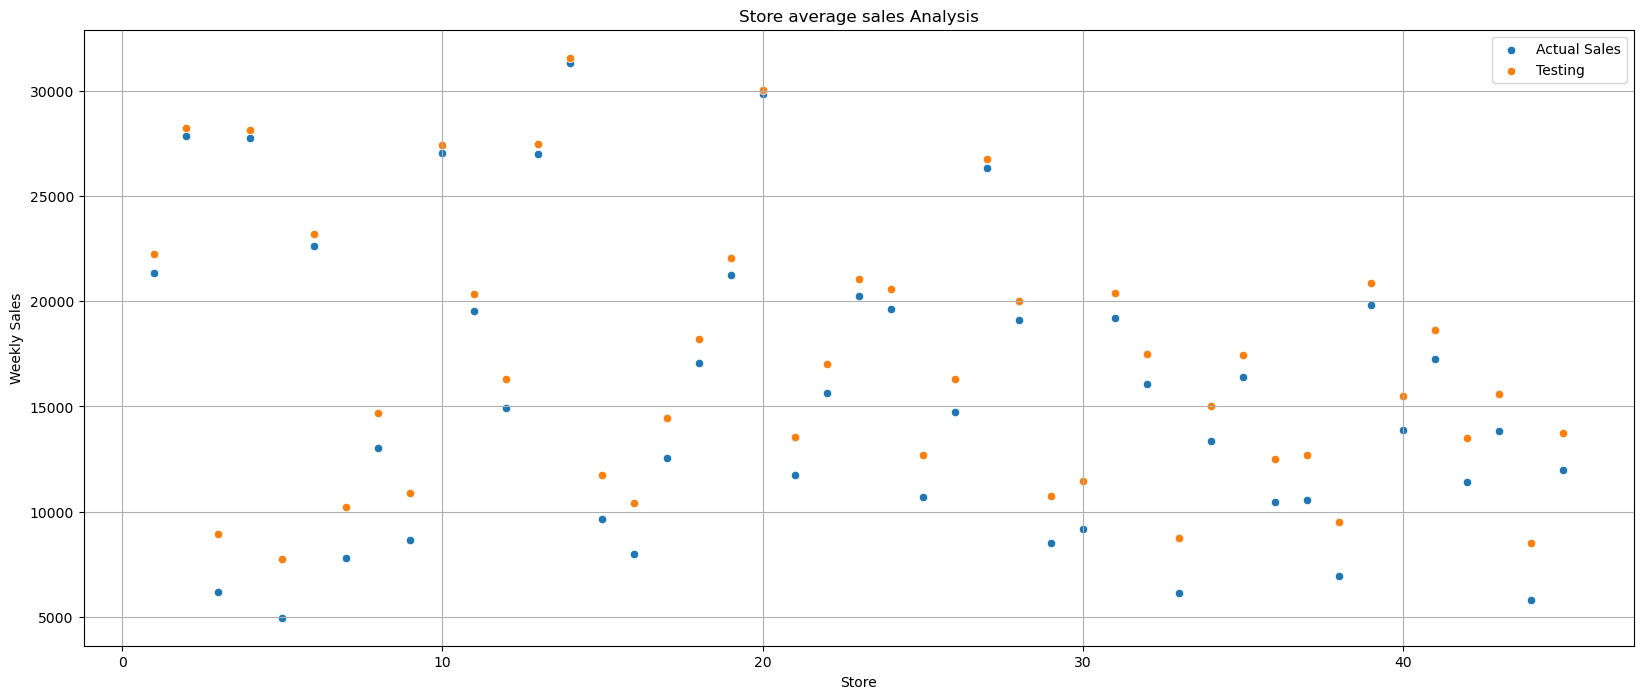

In [39]:
vldt5_grouped = vldt5.groupby(['Store'])[['weeklySales','y_vldt_pred']].mean()
train5_grouped = train5.groupby(['Store'])[['weeklySales','y_pred']].mean()
#print(vldt_grouped.head(5))

plt.figure(figsize=(20,8))

# Plot for Actual Sales in train_grouped
sns.scatterplot(x=vldt5_grouped.index, y=vldt5_grouped['weeklySales'], label='Actual Sales')

# Plot for Actual Sales in train_grouped
#sns.scatterplot(x=train5_grouped.index, y=train5_grouped['weeklySales'], label='Actual Sales')

# Plot for Training (y_pred) in train_grouped
#sns.scatterplot(x=train4_grouped.index, y=train4_grouped['y_pred'], label='Training')

# Plot for Testing (y_vldt_pred) in vldt_grouped
sns.scatterplot(x=vldt5_grouped.index, y=vldt5_grouped['y_vldt_pred'], label='Testing')
#plt.xticks(np.arange(34875, 53, step=1))
plt.xlabel('Store')
plt.ylabel('Weekly Sales')
plt.title('Store average sales Analysis')
plt.grid()
plt

#Show average store sells prediction

<module 'matplotlib.pyplot' from '/Users/yorkie/anaconda3/envs/cisc684/lib/python3.11/site-packages/matplotlib/pyplot.py'>

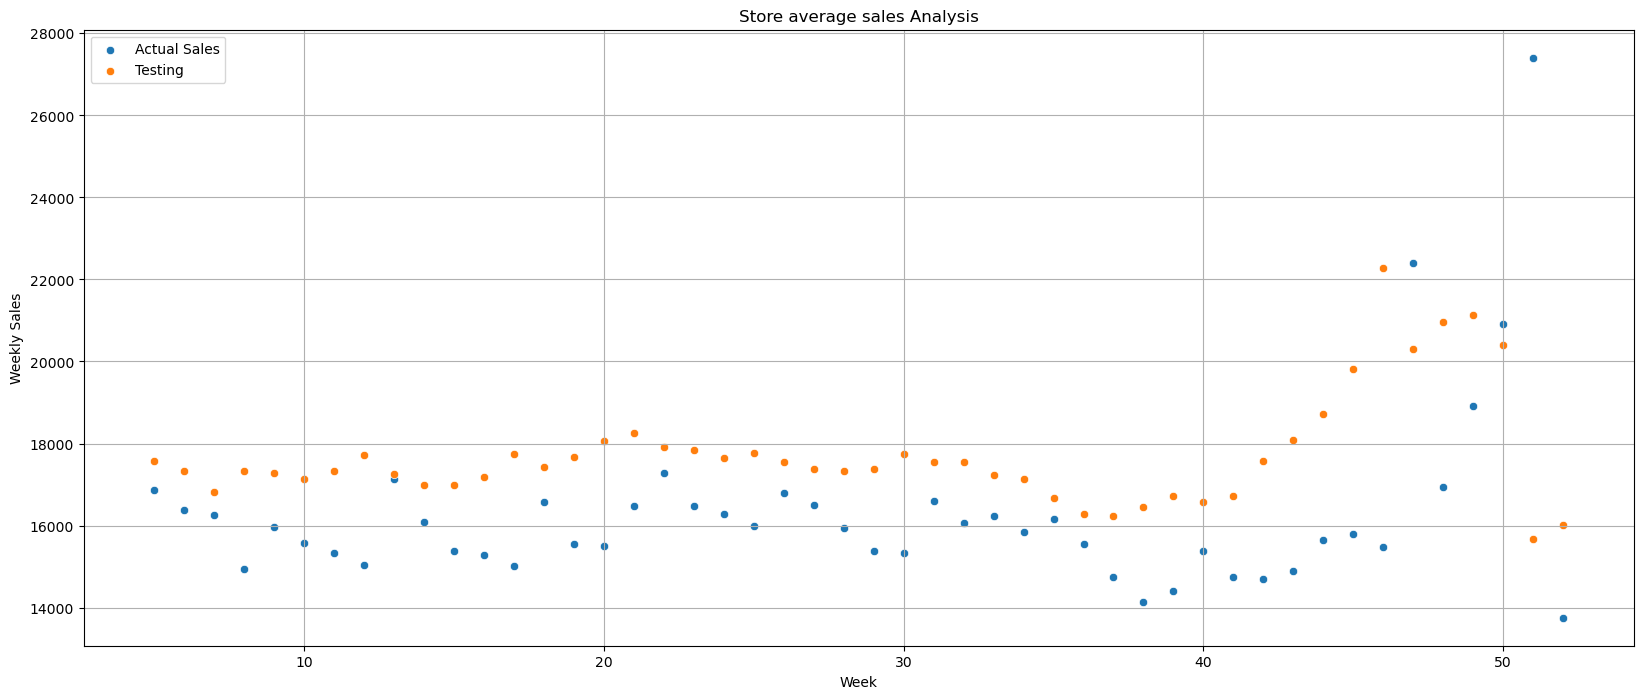

In [40]:
vldt5_grouped2 = vldt5.groupby(['Week'])[['weeklySales','y_vldt_pred']].mean()
train5_grouped2 = train5.groupby(['Week'])[['weeklySales','y_pred']].mean()
#print(vldt_grouped.head(5))

plt.figure(figsize=(20,8))

# Plot for Actual Sales in train_grouped
sns.scatterplot(x=vldt5_grouped2.index, y=vldt5_grouped2['weeklySales'], label='Actual Sales')

# Plot for Training (y_pred) in train_grouped
#sns.scatterplot(x=train4_grouped2.index, y=train4_grouped2['y_pred'], label='Training')

# Plot for Testing (y_vldt_pred) in vldt_grouped
sns.scatterplot(x=vldt5_grouped2.index, y=vldt5_grouped2['y_vldt_pred'], label='Testing')
#plt.xticks(np.arange(34875, 53, step=1))
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.title('Store average sales Analysis')
plt.grid()
plt

#Show average store sells prediction

## Model 6: GRU with all the features

In [14]:

df1 = train.loc[:, 'Store_1':'Type_C']
df2 = train.loc[:, 'Size_norm':'Size_norm']
df3 = train.loc[:, 'Temperature_norm':'Unemployment_norm']
df4 = train.loc[:, 'MarkDown1_Ind':'Holiday_Ind']
df5 = train.loc[:,'weeklySales_5':'weeklySales_1']
x_train = np.concatenate((df1, df2, df3, df4, df5), axis=1)
y_train = train['weeklySales']


df1 = vldt.loc[:, 'Store_1':'Type_C']
df2 = vldt.loc[:, 'Size_norm':'Size_norm']
df3 = vldt.loc[:, 'Temperature_norm':'Unemployment_norm']
df4 = vldt.loc[:, 'MarkDown1_Ind':'Holiday_Ind']
df5 = vldt.loc[:,'weeklySales_5':'weeklySales_1']
x_vldt = np.concatenate((df1, df2, df3, df4, df5), axis=1)
y_vldt = vldt['weeklySales']


y_train = np.array(y_train)
y_vldt = np.array(y_vldt)

x_train = torch.tensor(x_train).unsqueeze(2).float()
x_vldt = torch.tensor(x_vldt).unsqueeze(2).float()
y_train = torch.tensor(y_train).unsqueeze(1).float()
y_vldt = torch.tensor(y_vldt).unsqueeze(1).float()

print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_vldt.shape = ', x_vldt.shape)
print('y_vldt.shape = ', y_vldt.shape)
# Check for NaN values
nan_mask = torch.isnan(x_train)
#print("NaN values:", nan_mask)
print(sum(nan_mask))

# Check for infinite values
inf_mask = torch.isinf(x_train)
#print("Infinite values:", inf_mask)
print(sum(inf_mask))

x_train.shape =  torch.Size([264748, 197, 1])
y_train.shape =  torch.Size([264748, 1])
x_vldt.shape =  torch.Size([140461, 197, 1])
y_vldt.shape =  torch.Size([140461, 1])
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [

## LSTM autoregression

In [41]:
class LSTMNetbuildin(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, bias=True):
        super(LSTMNetbuildin, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        # Built-in LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_dim)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [42]:

model = LSTMNetbuildin(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)
criterion = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [43]:
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  1.102835774421692
Epoch  1 MSE:  0.8156474232673645
Epoch  2 MSE:  0.5354385375976562
Epoch  3 MSE:  0.22591212391853333
Epoch  4 MSE:  0.002948993816971779
Epoch  5 MSE:  0.35892143845558167
Epoch  6 MSE:  0.1639249622821808
Epoch  7 MSE:  0.008701713755726814
Epoch  8 MSE:  0.03037070482969284
Epoch  9 MSE:  0.09538072347640991
Epoch  10 MSE:  0.12902049720287323
Epoch  11 MSE:  0.12440745532512665
Epoch  12 MSE:  0.0940927043557167
Epoch  13 MSE:  0.05376346781849861
Epoch  14 MSE:  0.01906926929950714
Epoch  15 MSE:  0.0028207888826727867
Epoch  16 MSE:  0.009183013811707497
Epoch  17 MSE:  0.028590699657797813
Epoch  18 MSE:  0.04294754937291145
Epoch  19 MSE:  0.04117798060178757
Epoch  20 MSE:  0.027149604633450508
Epoch  21 MSE:  0.012004639953374863
Epoch  22 MSE:  0.0036480207927525043
Epoch  23 MSE:  0.0033601918257772923
Epoch  24 MSE:  0.008143664337694645
Epoch  25 MSE:  0.014052760787308216
Epoch  26 MSE:  0.018140854313969612
Epoch  27 MSE:  0.01902608200

Epoch  217 MSE:  0.0018097648862749338
Epoch  218 MSE:  0.0018005246529355645
Epoch  219 MSE:  0.001791243557818234
Epoch  220 MSE:  0.0017819216009229422
Epoch  221 MSE:  0.0017725585494190454
Epoch  222 MSE:  0.0017631545197218657
Epoch  223 MSE:  0.0017537091625854373
Epoch  224 MSE:  0.0017442228272557259
Epoch  225 MSE:  0.0017346953973174095
Epoch  226 MSE:  0.0017251266399398446
Epoch  227 MSE:  0.0017155169043689966
Epoch  228 MSE:  0.0017058661906048656
Epoch  229 MSE:  0.0016961743822321296
Epoch  230 MSE:  0.0016864414792507887
Epoch  231 MSE:  0.001676667365245521
Epoch  232 MSE:  0.0016668522730469704
Epoch  233 MSE:  0.001656995969824493
Epoch  234 MSE:  0.0016470985719934106
Epoch  235 MSE:  0.0016371600795537233
Epoch  236 MSE:  0.0016271807253360748
Epoch  237 MSE:  0.0016171602765098214
Epoch  238 MSE:  0.001607098849490285
Epoch  239 MSE:  0.0015969967935234308
Epoch  240 MSE:  0.0015868536429479718
Epoch  241 MSE:  0.0015766696305945516
Epoch  242 MSE:  0.0015664448

Epoch  427 MSE:  0.0002822979586198926
Epoch  428 MSE:  0.00028229146846570075
Epoch  429 MSE:  0.00028228535666130483
Epoch  430 MSE:  0.0002822796523105353
Epoch  431 MSE:  0.00028227418079040945
Epoch  432 MSE:  0.00028226894210092723
Epoch  433 MSE:  0.0002822638489305973
Epoch  434 MSE:  0.0002822588721755892
Epoch  435 MSE:  0.00028225392452441156
Epoch  436 MSE:  0.00028224909328855574
Epoch  437 MSE:  0.0002822442620526999
Epoch  438 MSE:  0.0002822393726091832
Epoch  439 MSE:  0.0002822345413733274
Epoch  440 MSE:  0.0002822296228259802
Epoch  441 MSE:  0.00028222467517480254
Epoch  442 MSE:  0.00028221969841979444
Epoch  443 MSE:  0.00028221463435329497
Epoch  444 MSE:  0.0002822095702867955
Epoch  445 MSE:  0.0002822043898049742
Epoch  446 MSE:  0.00028219918021932244
Epoch  447 MSE:  0.00028219394152984023
Epoch  448 MSE:  0.000282188702840358
Epoch  449 MSE:  0.0002821834059432149
Epoch  450 MSE:  0.00028217805083841085
Epoch  451 MSE:  0.00028217272483743727
Epoch  452 MS

In [44]:
predict = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
original = scaler.inverse_transform(y_train.detach().cpu().numpy())

train6 = train.copy()
train6['y_pred'] = predict
train6['weeklySales'] = original
print(np.mean(np.absolute(train6['weeklySales']-train6['y_pred'])*train6['Holiday_loss']))

2927.296682871908


In [45]:
# make predictions
with torch.no_grad():
    x_vldt = x_vldt.to(device)
    y_vldt_pred = model(x_vldt)


predict_vldt = scaler.inverse_transform(y_vldt_pred.detach().cpu().numpy())
original_vldt = scaler.inverse_transform(y_vldt.detach().cpu().numpy())
vldt6 = vldt.copy()
vldt6['y_vldt_pred'] = predict_vldt
vldt6['weeklySales'] = original_vldt

print(np.mean(np.absolute(vldt6['weeklySales']-vldt6['y_vldt_pred'])*vldt6['Holiday_loss']))

3562.355856302246


<module 'matplotlib.pyplot' from '/Users/yorkie/anaconda3/envs/cisc684/lib/python3.11/site-packages/matplotlib/pyplot.py'>

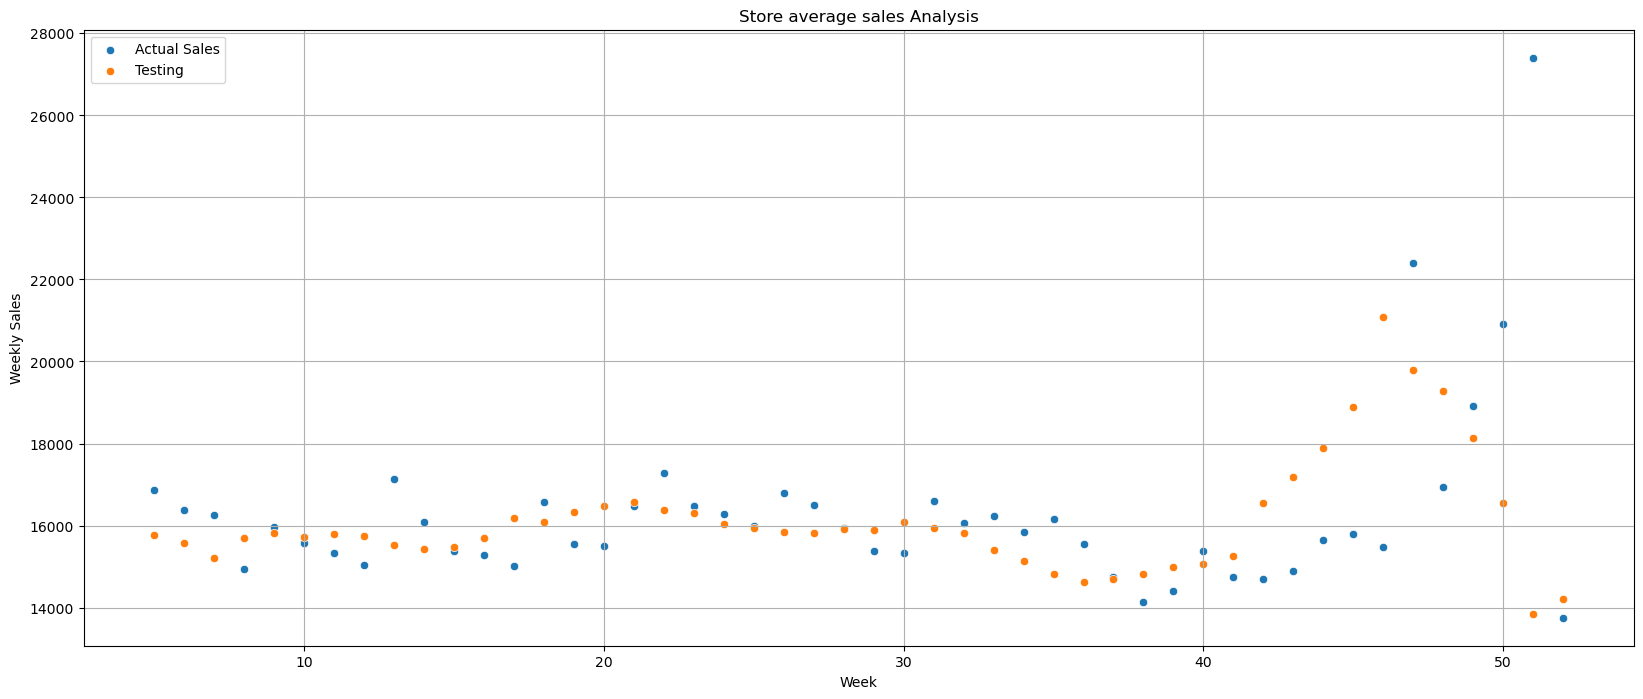

In [46]:
vldt6_grouped2 = vldt6.groupby(['Week'])[['weeklySales','y_vldt_pred']].mean()
train6_grouped2 = train6.groupby(['Week'])[['weeklySales','y_pred']].mean()
#print(vldt_grouped.head(5))

plt.figure(figsize=(20,8))

# Plot for Actual Sales in train_grouped
sns.scatterplot(x=vldt6_grouped2.index, y=vldt6_grouped2['weeklySales'], label='Actual Sales')

# Plot for Training (y_pred) in train_grouped
#sns.scatterplot(x=train4_grouped2.index, y=train4_grouped2['y_pred'], label='Training')

# Plot for Testing (y_vldt_pred) in vldt_grouped
sns.scatterplot(x=vldt6_grouped2.index, y=vldt6_grouped2['y_vldt_pred'], label='Testing')
#plt.xticks(np.arange(34875, 53, step=1))
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.title('Store average sales Analysis')
plt.grid()
plt

#Show average store sells prediction